In [2]:
from matplotlib import pyplot as plt
import platform, os, sys, h5py
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append('/mnt/s/_Data/160603 - EonHe M016v5/modules')
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    %config InlineBackend.figure_format='retina'

from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal
from HeliumSurface.static_surface import *
from ipywidgets import interact

%matplotlib inline

Could not import BEM module. Please do so manually.


In [3]:
f0 = 6.5E9
Z0 = 70.0
hbar = 1.055E-34
me = 9.11E-31
qe = 1.602E-19
eps0 = 8.85E-12

omega0 = 2*np.pi*f0
L = Z0/omega0
beta = 3E5

def trap_curv(V):
    k0 = 0.10E12
    return V*k0

In [4]:
def ev_plus(V, n):
    return 1/(2*me) * ((me*omega0**2 + qe*trap_curv(V)) + \
                       np.sqrt((me*omega0**2-qe*trap_curv(V))**2+4*n*me*qe**2*beta**2*L*omega0**4))

def ev_minus(V, n):
    return 1/(2*me) * ((me*omega0**2 + qe*trap_curv(V)) - \
                       np.sqrt((me*omega0**2-qe*trap_curv(V))**2+4*n*me*qe**2*beta**2*L*omega0**4))

/Users/gkoolstra/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt
/Users/gkoolstra/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in sqrt


(6.49, 6.51)

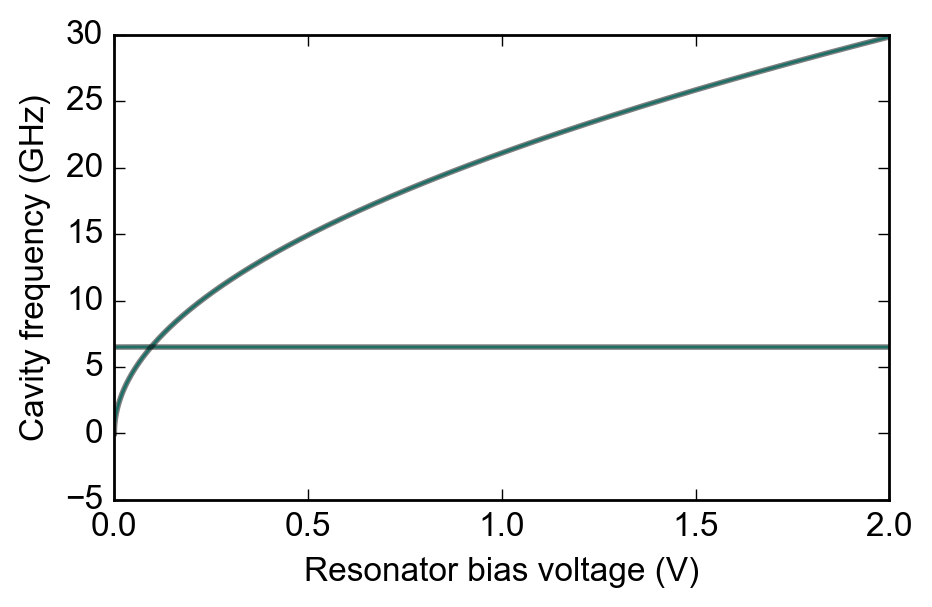

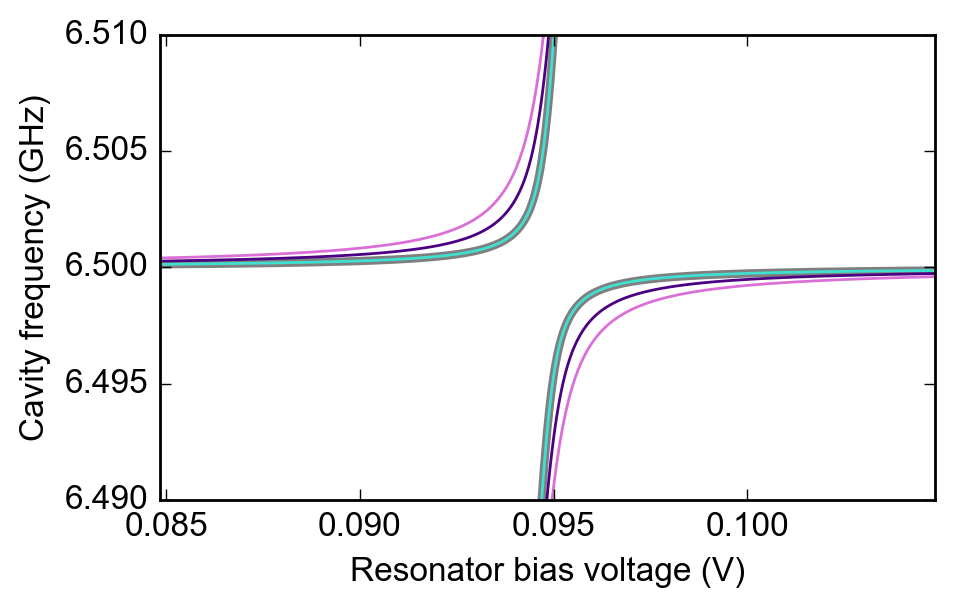

In [16]:
%matplotlib inline

resV = np.linspace(0.00, 2.00, 5e4)
cav_freq = [np.sqrt(ev_plus(V, 1))/(2*np.pi*1E9) for V in resV]
el_freq = [np.sqrt(ev_minus(V, 1))/(2*np.pi*1E9) for V in resV]

plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(resV, cav_freq, '-', color='turquoise')
plt.plot(resV, el_freq, '-', color='turquoise')
#plt.plot(resV, 1/(2*np.pi*1E9) * np.sqrt(qe*trap_curv(resV)/me))
plt.xlabel("Resonator bias voltage (V)")
plt.ylabel("Cavity frequency (GHz)")

def jaynes_cummings(V, n):
    g = 0.5 * qe * beta * np.sqrt(Z0*omega0/me)
    omegae = np.sqrt(qe*trap_curv(V)/me)
    return 0.5*(omega0 + omegae - np.sqrt(4*n*g**2 + (omegae - omega0)**2)), 0.5*(omega0 + omegae + np.sqrt(4*n*g**2 + (omegae - omega0)**2))
    
plt.plot(resV, 1/(2*np.pi*1E9) * jaynes_cummings(resV, 1.0)[0], '-k', alpha=0.5, lw=2.0)
plt.plot(resV, 1/(2*np.pi*1E9) * jaynes_cummings(resV, 1.0)[1], '-k', alpha=0.5, lw=2.0)
#plt.ylim(6.4, 6.6)
#plt.xlim(0.08, 0.10)

plt.figure(figsize=(5.,3.))
common.configure_axes(12)

plt.plot(resV, 1/(2*np.pi*1E9) * jaynes_cummings(resV, 1.0)[0], '-k', alpha=0.5, lw=3.0)
plt.plot(resV, 1/(2*np.pi*1E9) * jaynes_cummings(resV, 1.0)[1], '-k', alpha=0.5, lw=3.0)

plt.plot(resV, cav_freq, '-', color='turquoise')
plt.plot(resV, el_freq, '-', color='turquoise')

for color, n in zip(['indigo', 'orchid'], [2,3]):
    plt.plot(resV, [np.sqrt(ev_minus(V, n))/(2*np.pi*1E9) for V in resV], '-', color=color)
    plt.plot(resV, [np.sqrt(ev_plus(V, n))/(2*np.pi*1E9) for V in resV], '-', color=color)

intercept = resV[common.find_nearest(np.array(ev_plus(resV, 1))-np.array(ev_minus(resV, 1)), 0)]

plt.xlabel("Resonator bias voltage (V)")
plt.ylabel("Cavity frequency (GHz)")
plt.xlim(intercept-0.01, intercept + 0.01)
plt.ylim(6.49, 6.51)

(0.085, 0.105)

/Users/gkoolstra/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


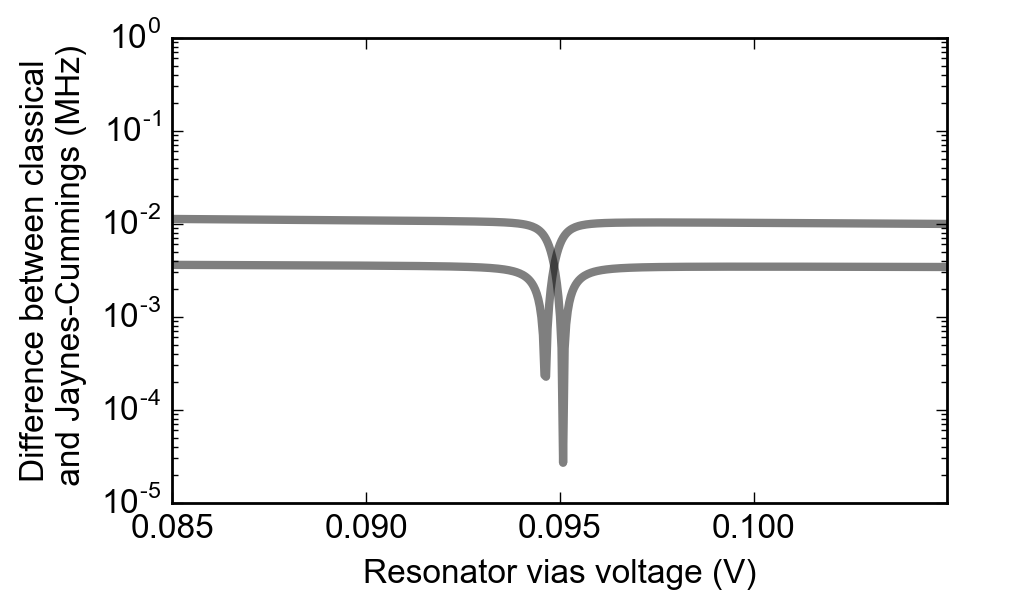

In [25]:
plt.figure(figsize=(5.,3.))
common.configure_axes(12)

plt.plot(resV, 1E3 * np.abs(1/(2*np.pi*1E9) * jaynes_cummings(resV, 1)[0]-el_freq), '-k', alpha=0.5, lw=3.0)
plt.plot(resV, 1E3 * np.abs(1/(2*np.pi*1E9) * jaynes_cummings(resV, 1)[1]-cav_freq), '-k', alpha=0.5, lw=3.0)

plt.yscale('log')
plt.ylabel("Difference between classical\n and Jaynes-Cummings (MHz)")
plt.xlabel("Resonator vias voltage (V)")

plt.xlim(0.085, 0.105)